<h1>Predicting the Quality of Education from Wikipedia Articles</h1>

In [63]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import wikipedia

import csv
import time
import os
import pickle
import random

First, we query Wikipedia to get the relevant articles. We only use 100 articles as to avoid throttling Wikipedia's API.

In [15]:
with open('DataSets/NN_CollegeData.csv', 'r') as f:
    data = csv.reader(f)
    next(data) # Skip the header row.
    
    # The college name is in the 2nd column and the quintile of graduation is in the 4th
    colleges = [(row[1], int(row[3])) for row in data]
 

In [18]:
def query_wikipedia(schoolname):
    time.sleep(1) # To avoid throttling Wikipedia
    return wikipedia.page(schoolname).content

In [52]:
NUM_ARTICLES = 100

articles = {}
labels = {}
failed = []

if os.path.isfile('wikipedia_data.pickle') and os.path.isfile('wikipedia_labels.pickle'):
    with open('wikipedia_data.pickle', 'rb') as f:
        articles = pickle.load(f)
    with open('wikipedia_labels.pickle', 'rb') as f:
        labels = pickle.load(f)
else:
    start = time.time()
    for college, label in colleges:
        try :
            print(college)
            articles[college] = query_wikipedia(college)
            labels[college] = label
            if len(articles > NUM_ARTICLES):
                break
        except:
            failed.append(college)
    print("Time Elapsed: ", time.time() - start)
    
    with open('wikipedia_data.pickle', 'wb') as f:
        pickle.dump(articles, f)  
    with open('wikipedia_labels.pickle', 'wb') as f:
        pickle.dump(labels, f)
    
print(len(articles), len(failed))

100 0


Now we need to convert the raw text data into numpy vectors that the Neural Net can process

In [291]:
from string import ascii_lowercase, whitespace

allowable_characters = ascii_lowercase + punctuation + whitespace
article_size = 8000 # Arbitrarily cut off at 8000 characters so everything is uniform
def preprocess_article(article):
    return "".join(char for char in article.lower() if char in allowable_characters)

def vectorize_article(article, input_length=10):
    """Turns a preprocessed vector into a vector for use by the Neural Network"""
    character_indices = [allowable_characters.index(c) for c in article]
    if len(character_indices) < article_size:
        chars_to_pad = article_size - len(character_indices)
        padded_character_indices = np.pad(character_indices, (0, chars_to_pad), 'constant')
    else:
        padded_character_indices = character_indices[:article_size]
    
    assert len(padded_character_indices) == article_size
    return np.array(padded_character_indices)#[i:i+input_length] 
                    #for i in range(len(padded_character_indices) - input_length)])

def vectorize_labels(label):
    v = np.zeros(5)
    v[label] = 1
    return v

In [292]:
input_length = 10

article_vectors = {
    college_name: vectorize_article(preprocess_article(article_content), 
                                    input_length=input_length) 
    for college_name, article_content in articles.items()
}

label_vectors = {
    college_name: vectorize_labels(label)
    for college_name, label in labels.items()
}

colleges_to_analyze = list(college for college in articles.keys())
print(vectorize_article(preprocess_article(
               articles[colleges_to_analyze[0]])))

[ 0 11  0 ..., 11  8 13]


In [293]:
training_split = int(.9 * NUM_ARTICLES)
random.shuffle(colleges_to_analyze)

training_colleges = colleges_to_analyze[:training_split]
testing_colleges = colleges_to_analyze[training_split:]

X_train = np.array([article_vectors[college] for college in training_colleges])
Y_train = np.array([label_vectors[college] for college in training_colleges])
X_test = np.array([article_vectors[college] for college in testing_colleges])
Y_test = np.array([label_vectors[college] for college in testing_colleges])

print(X_train[0].shape)

(8000,)


In [294]:
from keras.models import load_model # File parsing

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

In [295]:
model = Sequential()
model.add(Embedding(len(allowable_characters), 64, input_length=8000))
model.add(LSTM(20))
model.add(Dense(5, activation='tanh'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 8000, 64)          4096      
_________________________________________________________________
lstm_22 (LSTM)               (None, 20)                6800      
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 105       
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________
None


In [298]:
acc = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=8, batch_size=64)

Train on 90 samples, validate on 10 samples
Epoch 1/8
90/90 [==============================] - 13s 145ms/step - loss: 1.0198 - acc: 0.8000 - val_loss: 0.6407 - val_acc: 0.8000
Epoch 2/8
90/90 [==============================] - 14s 159ms/step - loss: 0.7165 - acc: 0.8000 - val_loss: 0.6032 - val_acc: 0.8000
Epoch 3/8
90/90 [==============================] - 17s 186ms/step - loss: 0.6136 - acc: 0.8000 - val_loss: 0.5768 - val_acc: 0.8000
Epoch 4/8
90/90 [==============================] - 16s 183ms/step - loss: 0.5739 - acc: 0.8000 - val_loss: 0.5560 - val_acc: 0.8000
Epoch 5/8
90/90 [==============================] - 14s 161ms/step - loss: 0.5463 - acc: 0.8000 - val_loss: 0.5386 - val_acc: 0.8000
Epoch 6/8
90/90 [==============================] - 18s 196ms/step - loss: 0.5258 - acc: 0.8000 - val_loss: 0.5235 - val_acc: 0.8000
Epoch 7/8
90/90 [==============================] - 16s 174ms/step - loss: 0.5083 - acc: 0.8000 - val_loss: 0.5098 - val_acc: 0.8000
Epoch 8/8
90/90 [===============

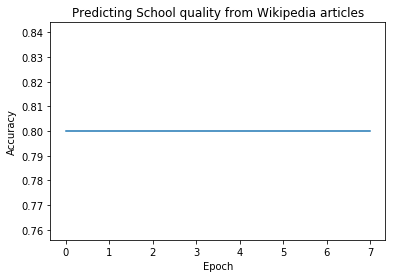

In [301]:
plt.plot(acc.history['acc'])
plt.title("Predicting School quality from Wikipedia articles")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('accuracy.png')
plt.show()
